In [1]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier

In [2]:
N_CUSTOMERS_REDUCED = 5000
USE_REDUCED = False
cat_vars =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 

In [3]:
if USE_REDUCED:
    df = pd.read_csv('train_data_reduced.csv')
    df_lab = pd.read_csv('train_labels_reduced.csv')
    df = df.drop('Unnamed: 0', axis=1)
    df_lab = df_lab.drop('Unnamed: 0', axis=1)
else:
    df = pd.read_csv('/dev/shm/train_data.csv')
    df_lab = pd.read_csv('/dev/shm/train_labels.csv')
    
# TODO let's load this l8r
# df_test = pd.read_csv('/dev/shm/test_data.csv')

### Dataset reduction (fast prototyping!)

In [4]:
# This makes no sense if we're already operating
# on a reduced dataframe.
if not USE_REDUCED:
    unique_customers = df.customer_ID.unique()
    customer_selection = np.random.choice(unique_customers, size=N_CUSTOMERS_REDUCED, replace=False)

    df_red = df[df.customer_ID.isin(customer_selection)]
    df_lab_red = df_lab[df_lab.customer_ID.isin(customer_selection)]

    df_red.to_csv('train_data_reduced.csv')
    df_lab_red.to_csv('train_labels_reduced.csv')

## Data Exploration

In [5]:
print(f'Rows per customer: {df.shape[0] / df.customer_ID.unique().shape[0]}',)

Rows per customer: 12.053376130116165


In [6]:
df_with_labels = df.set_index('customer_ID').join(df_lab.set_index('customer_ID'))

In [7]:
len(df_with_labels)

5531451

### Missing Values

In [8]:
nan_per_column = df_with_labels.isna().sum()

In [9]:
nan_percentage = nan_per_column / len(df_with_labels)
nan_percentage = nan_percentage[nan_percentage != 0]

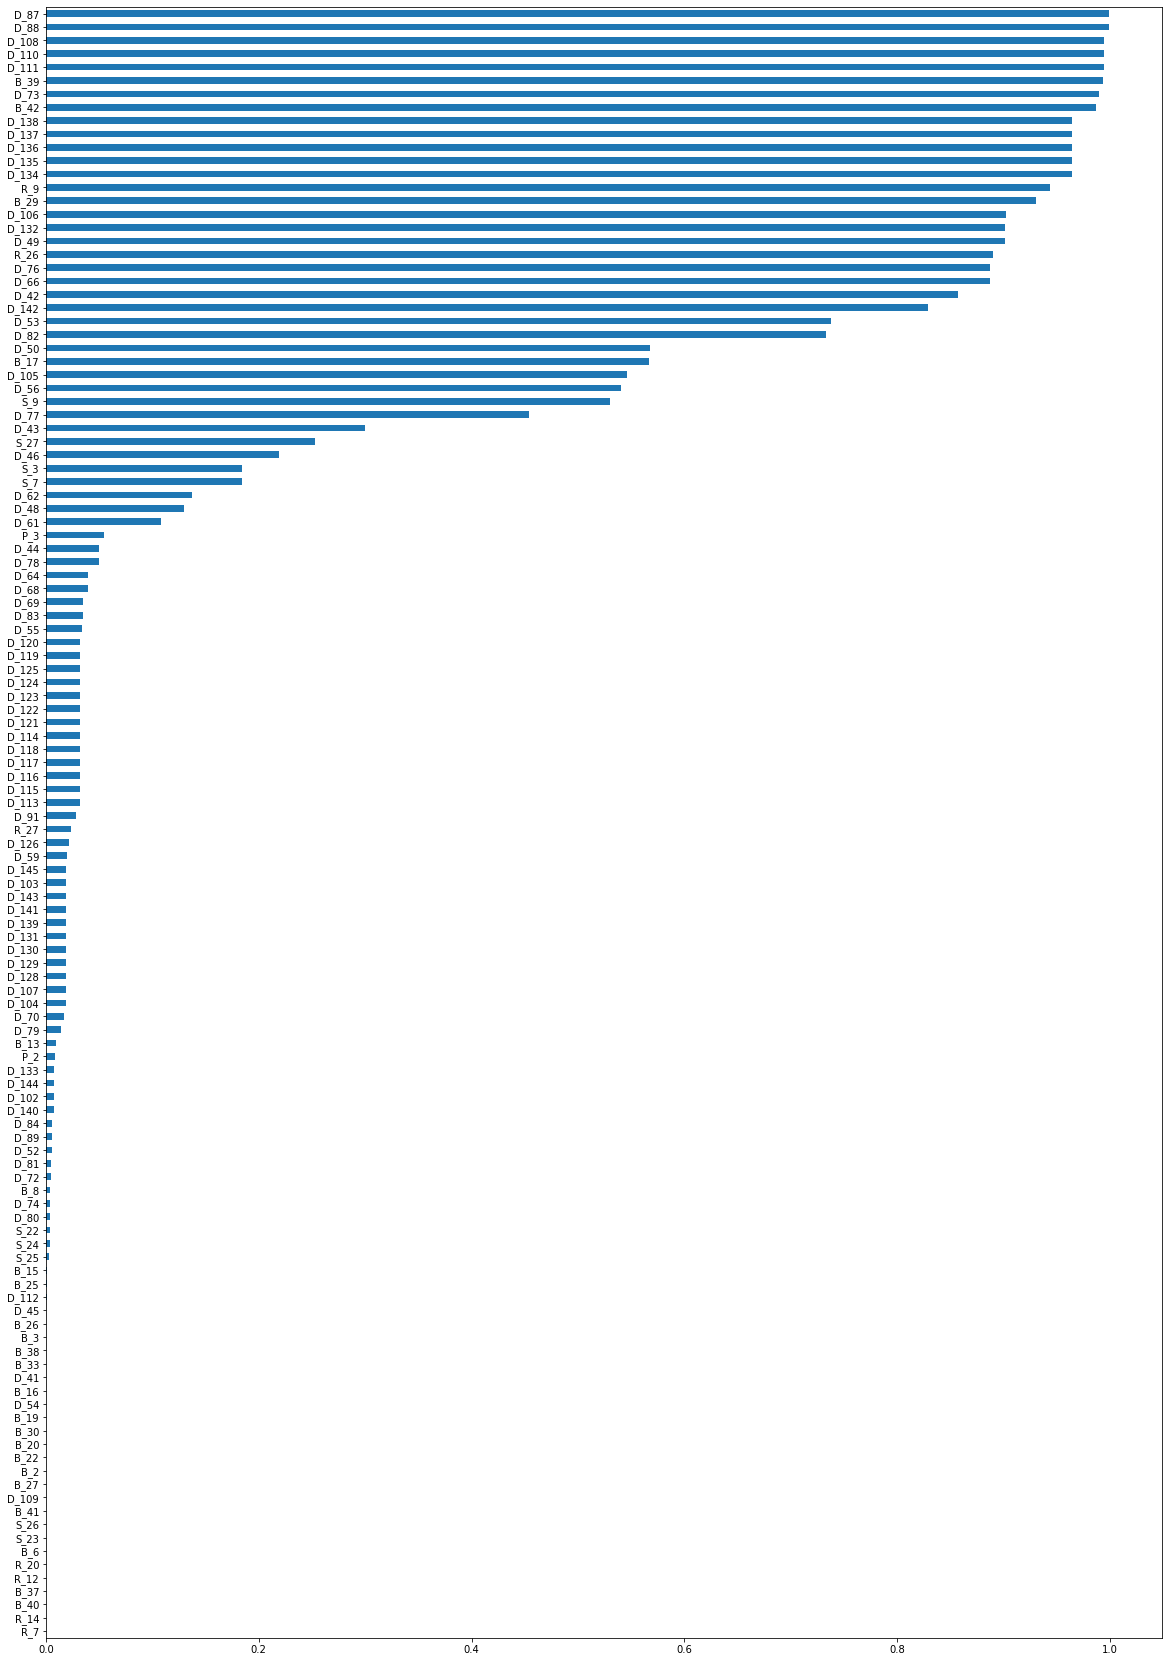

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
nan_percentage.sort_values().plot(kind='barh')
fig.set_size_inches(20, 30)

### Categorical Variables

### Combine Rows into one

In [11]:
def preprocess(dataframe):
    cat_dtypes = dataframe.dtypes[cat_vars]
    dataframe[cat_vars] = dataframe[cat_vars].where(~dataframe[cat_vars].isna(), 0)

    dataframe = dataframe.astype({k: np.int32 for k in cat_dtypes[cat_dtypes == np.float64].keys()})
    #df_no_nan = df.replace(np.nan, "")
    #df_wide = dataframe.groupby('customer_ID').sum().unstack()

    df_reset = dataframe.reset_index()
    df_reset['group_index'] = dataframe.groupby('customer_ID').cumcount()
    df_reindex = df_reset.set_index(['customer_ID', 'group_index'])
    df_reindex = df_reindex[~df_reindex.index.duplicated(keep='last')] #TBD why needed?

    df_unstacked = df_reindex.unstack()

    df_unstacked = df_unstacked.drop('index', level=0, axis=1)
    df_unstacked = df_unstacked.drop('S_2', level=0, axis=1)

    df_unstacked.columns = [' '.join(map(str, col)).strip() for col in df_unstacked.columns.values]

    # Convert categorical features in wide dataframe to integers
    cat_vars_wide = list(filter(lambda x: any([y in x for y in cat_vars]), df_unstacked.columns))
    cat_dtypes = df_unstacked.dtypes[cat_vars_wide]

    df_unstacked = df_unstacked.astype({k: 'Int32' for k in cat_dtypes[cat_dtypes==np.float64].keys()})
    df_unstacked = df_unstacked.replace(np.nan, -1)
    cat_dtypes = df_unstacked.dtypes[cat_vars_wide]
    df_unstacked = df_unstacked.astype({k: np.int32 for k in cat_dtypes[cat_dtypes=='Int32'].keys()})
    return df_unstacked, cat_vars_wide

### Catboost

In [12]:
df_preprocessed, cat_vars_wide = preprocess(df)

In [13]:
df_preprocessed

,P_2 0,P_2 1,P_2 2,P_2 3,P_2 4,P_2 5,P_2 6,P_2 7,P_2 8,P_2 9,...,D_145 3,D_145 4,D_145 5,D_145 6,D_145 7,D_145 8,D_145 9,D_145 10,D_145 11,D_145 12
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.938469,0.936665,0.954180,0.960384,0.947248,0.945964,0.940705,0.914767,0.950845,0.868580,...,0.009600,0.009827,0.002884,0.002225,0.007385,0.000995,0.009068,0.006362,0.004204,0.008533
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.929122,0.918431,0.922563,0.919253,0.901860,0.910458,0.904814,0.916234,0.873512,0.861109,...,0.006308,0.005527,0.009390,0.000796,0.002165,0.003408,0.007844,0.002178,0.003584,0.008514
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.876615,0.887385,0.884522,0.852514,0.891656,0.902419,0.904482,0.903964,0.797670,0.872014,...,0.005859,0.005110,0.006932,0.004045,0.006078,0.006824,0.006133,0.000563,0.005606,0.003444
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.567442,0.568356,0.581232,0.581547,0.598278,0.594502,0.591553,0.606677,0.622756,0.614427,...,0.007468,0.000029,0.003292,0.009836,0.006356,0.007719,0.000614,0.000834,0.006847,0.002983
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.936842,0.938100,0.937438,0.935854,0.940382,0.805045,0.861652,0.865890,0.860753,0.877417,...,0.004366,0.000083,0.005485,0.002089,0.005487,0.002884,0.009169,0.009652,0.002059,0.000905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.859869,0.871607,0.864723,0.869193,0.872287,0.885777,0.895553,0.855642,0.730505,0.833949,...,0.000145,0.007800,0.001736,0.007075,0.006908,0.007120,0.005220,0.002532,0.005594,0.004843
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.863153,0.863433,0.867611,0.868090,0.867893,0.847000,0.864945,0.866514,0.868121,0.868006,...,0.007160,0.007642,0.003204,0.007067,0.007776,0.006505,0.003952,0.002929,0.006188,0.006435
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.793724,0.780039,0.780914,0.768016,0.772608,0.756983,0.802887,0.802953,0.793587,0.795304,...,0.000204,0.003375,0.002068,0.005654,0.003628,0.000807,0.006776,-1.000000,0.006619,0.002148


In [14]:
pool = Pool(df_preprocessed, df_lab['target'], cat_vars_wide)

In [15]:
model = CatBoostClassifier(iterations=100)

In [16]:
model.fit(pool)

Learning rate set to 0.5
0:	learn: 0.3651574	total: 602ms	remaining: 59.6s
1:	learn: 0.3098660	total: 1.03s	remaining: 50.3s
2:	learn: 0.2884336	total: 1.57s	remaining: 51s
3:	learn: 0.2775087	total: 1.97s	remaining: 47.4s
4:	learn: 0.2710045	total: 2.5s	remaining: 47.4s
5:	learn: 0.2667035	total: 2.98s	remaining: 46.8s
6:	learn: 0.2624988	total: 3.39s	remaining: 45.1s
7:	learn: 0.2599311	total: 3.84s	remaining: 44.2s
8:	learn: 0.2583815	total: 4.18s	remaining: 42.3s
9:	learn: 0.2559849	total: 4.61s	remaining: 41.5s
10:	learn: 0.2538363	total: 5.1s	remaining: 41.3s
11:	learn: 0.2524412	total: 5.54s	remaining: 40.6s
12:	learn: 0.2507745	total: 6.01s	remaining: 40.2s
13:	learn: 0.2493478	total: 6.38s	remaining: 39.2s
14:	learn: 0.2481134	total: 6.87s	remaining: 38.9s
15:	learn: 0.2467759	total: 7.3s	remaining: 38.3s
16:	learn: 0.2456354	total: 7.66s	remaining: 37.4s
17:	learn: 0.2448138	total: 8.02s	remaining: 36.6s
18:	learn: 0.2438981	total: 8.43s	remaining: 35.9s
19:	learn: 0.2432199	

# Evaluation

In [17]:
df_test = pd.read_csv('/dev/shm/test_data.csv')

In [ ]:
df_test_preprocessed, cat_vars_wide = preprocess(df_test)

In [ ]:
preds = model.predict_proba(df_test_preprocessed)[:,1]

In [ ]:
preds

In [ ]:
df_preds = df_test_preprocessed.assign(p=preds)

In [ ]:
a=df_preds['p'].reset_index()

In [ ]:
a.groupby('customer_ID').mean().rename(columns={"p":"prediction"}).to_csv('preds_wideframe_prototype.csv')